In [1]:
### basic imports ###
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd ; import seaborn as sns 

#### Getting Stock Data

In [2]:
import yfinance as yf
import datetime

In [3]:
## mention the ticekrs of the stocks you're interested in over the time interval 'start' and 'end'
stocks= ['MSFT', 'AAPL', 'IBM', 'GOOGL', 'AMZN', 'NFLX', 'META'] 
start = datetime.datetime(2020,1,1); end = datetime.datetime(2023,1,1)

timeseries_data = pd.DataFrame()
for stock in stocks:
    timeseries_data[stock] = yf.download(stock, start= start, end= end, progress=False )['Close'] ## here we will downoad the data from yahoo



In [4]:
## return data is obtained by monitoring the log of ration between stock-prices of two consecutive days
return_data = timeseries_data/timeseries_data.shift(1)
return_data = np.log(return_data[1:])

## the mean return for each of the assets is called the 'Expected Return'
mean_returns = return_data.mean()


## create covariance matrix, this matrix denotes how much the return from a particular asset is correlated with another asset
cov_matrix = return_data.cov()
for stock in stocks : cov_matrix[stock][stock] = 0


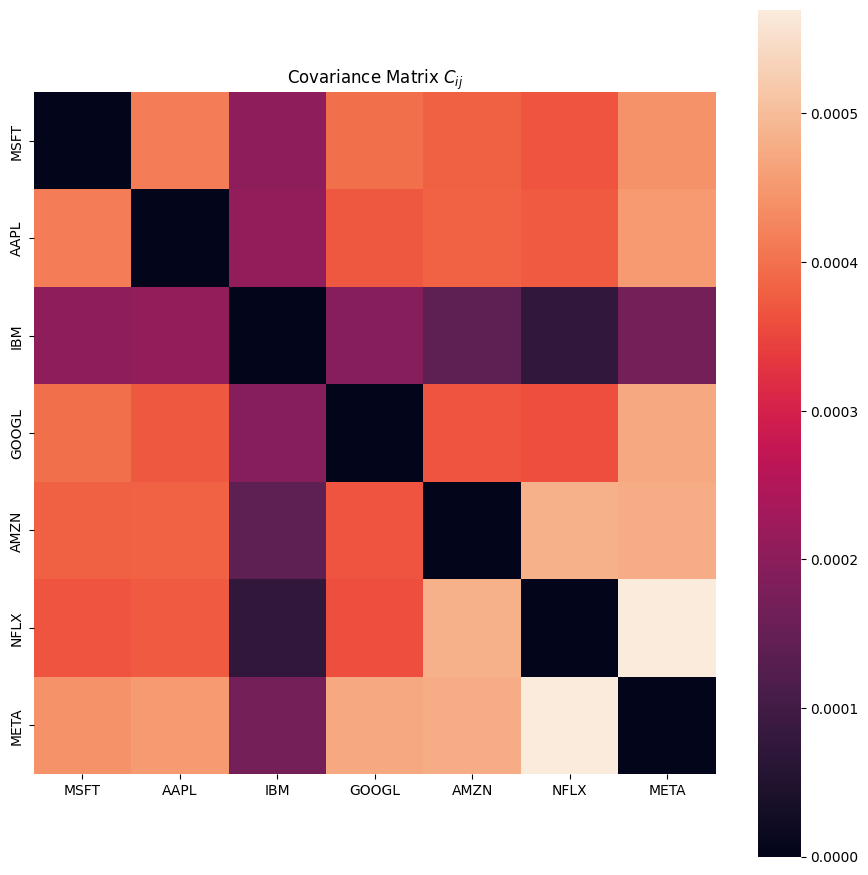

In [5]:
plt.figure(figsize=(11,11))
sns.heatmap(cov_matrix, square=True )
plt.title('Covariance Matrix $C_{ij}$')
plt.show()

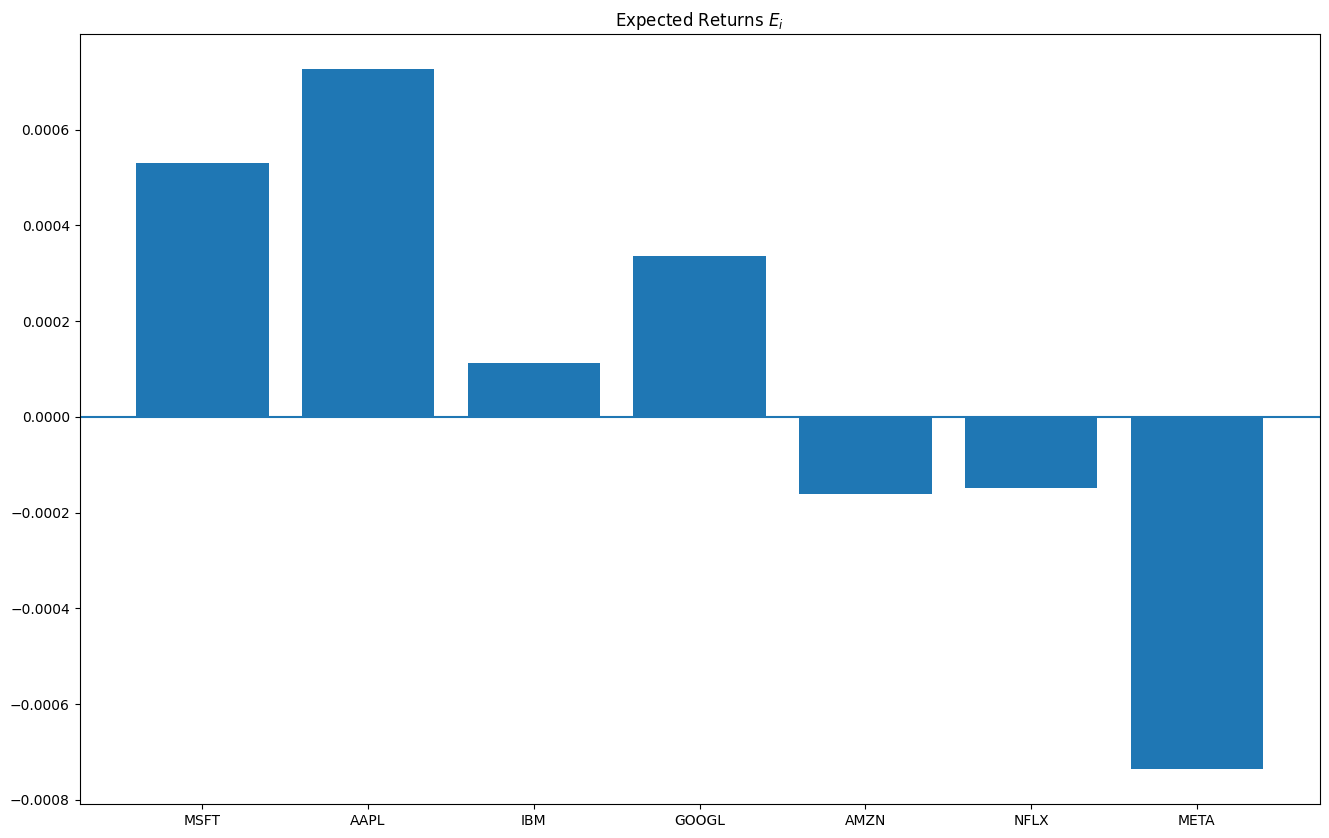

In [6]:
plt.figure(figsize=(16,10))
plt.bar(range(len(stocks)), mean_returns, tick_label= stocks )
plt.axhline(y=0)
plt.title('Expected Returns $E_i$')
plt.show()

### Portfolio Optimisation

In portfolio optimisation we aim to divide one's investment among the various assets (called the portfolio $\mathtt{P}$) in the set $\mathtt{U}(P)$ such that the expected returns $\mathcal{E}(P)$ is maximised and the risk $\mathcal{R}$ is minimised. In our simplified version of the problem we are allowed to either select or not select an asset into the portfolio $\mathtt{P}$ 


First we will need to encode the problem into a mathematical form. We will start by representing the selection of the $i$th asset with a binary varaible $x_i$, i.e $x_i = 1$ would indicate that asset $i$ has been selected in the portfolio $\mathtt{P}$ whereas $x_i = 0 $ would indicate otherwise. 

The expected return is given by $\mathcal{E} = \sum_{i \in \mathtt{U}} E_i x_i$, and the risk is given by $\mathcal{R} = \sum_{ij \in \mathtt{U}} x_iC_{ij}x_j$. 

The concept of expected returns follows simple from the fact that if asset $i$ has an expected return of $E_i$ then by selecting the asset (i.e if $x_i = 1$) we include its comparison $E_ix_i$ to the net expected return $\mathcal{E}(P)$. 

To understand risk $\mathcal{R}$, observe that the terms that contribute to the sum has the form $x_i C_{ij} x_j$ which is non-zero only if both the asset $i$ and asset $j$ are selected i.e ($x_i C_{ij} x_j \neq0 \;\ \text{if}\ i,j \neq 0 $). This captures the idea that if both assets are selected together we need to consider the variance in returns that arises due to their correlation $C_{ij}$. 

Thus we can summarise the above concepts into a single function that we will need to optimise.
$$   \mathcal{O}(P) :  min_{\vec{x}\in (1,0)^n} \: \;  \sum_{ij \in \mathtt{U}} x_i C_{ij} x_j - \sum_{i\in \mathtt{U}} E_{i} x_i
$$
The $min_{\vec{x} \in (1,0)^n}$ indicates that we need to find a binary vector $\vec{x}$ (binary vector means its a vector of 1s and 0s, and $n$ is the total number assets in $\mathtt{U}$) such that the optimisation function is minimised. The value of the function is also reffered to as *cost*  or *energy*, and the space of all possible solutions is called *energy-landscape*
 
Problems like this are popularly termed as Quadratic Unconstrained Binary Optimisation problem (QUBO) or sometimes as Binary Quadratic Model (BQM) in literature of optimisation theory, and ther exists a wide range of techniques to solve such problems. 

###### **NB :** There exits conventional difference between the notion of BQMs and QUBOs, but that will not be relavant for our work and we will use them interchangeably.


**Eg:** The figure shows an example energy landscape, the aim is always to find the states with minimum energy 

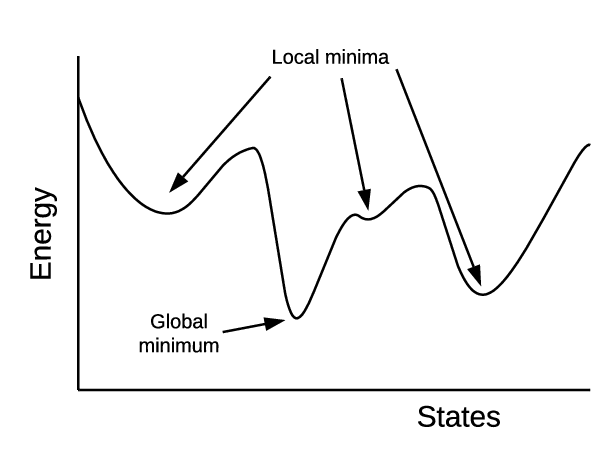

### Classical Optimisation 

In [16]:
import dimod 
from dimod import BinaryQuadraticModel as BQM 
import neal 

In [17]:
## setup a Binary Quadratic MOdel
portfolio_bqm = BQM('BINARY')
## setup binary variables correposnding to each of the assets 
for asset in stocks : portfolio_bqm.add_variable(asset)

In [18]:
## next we build the quadratic optimisation model step-by-step

## first we add contribution of the maximising Expected Returns
for stock in stocks: portfolio_bqm.add_linear_from({stock: -1*mean_returns[stock]})

## second we add contributions of minimising the RIsk
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: portfolio_bqm.add_quadratic(stock_i, stock_j, cov_matrix[stock_i][stock_j] )


In [19]:
portfolio_bqm

BinaryQuadraticModel({'MSFT': -0.0005309236769950078, 'AAPL': -0.0007262803536775122, 'IBM': -0.00011201552626766938, 'GOOGL': -0.00033652626460847594, 'AMZN': 0.00016160549463619756, 'NFLX': 0.00014827577905974636, 'META': 0.0007360772415280037}, {('AAPL', 'MSFT'): 0.0008303010366321728, ('IBM', 'MSFT'): 0.0004088946808221773, ('IBM', 'AAPL'): 0.0004185975397534209, ('GOOGL', 'MSFT'): 0.0007949453616991686, ('GOOGL', 'AAPL'): 0.000743490718917029, ('GOOGL', 'IBM'): 0.0003842607668841931, ('AMZN', 'MSFT'): 0.0007596652347562505, ('AMZN', 'AAPL'): 0.0007623611598484921, ('AMZN', 'IBM'): 0.0002794199446021926, ('AMZN', 'GOOGL'): 0.0007315842953584596, ('NFLX', 'MSFT'): 0.0007322779279247102, ('NFLX', 'AAPL'): 0.0007471764648866058, ('NFLX', 'IBM'): 0.00014874253244023035, ('NFLX', 'GOOGL'): 0.0007170223196843463, ('NFLX', 'AMZN'): 0.0009664600658533095, ('META', 'MSFT'): 0.0008833948633268355, ('META', 'AAPL'): 0.0009054922595416377, ('META', 'IBM'): 0.00034182455554541806, ('META', 'GOO

##### Simulated Annealing

There exists a multitude of classical optimisation techniques that could be used to solve QUBO problems. For our problem we will use a technique called *Simulated-Annealing*. Basically this is a parobabilitstic optimisation algorithm which begins by ascribing equal probability on all the possible solutions and then interatively modifies the probability distributions so that only near-optimal solutions end up with high probability. 

The probability distributions iteself is obtained by a randomly traversing the space of all possible solutions, i.e we move from one possible state to another with certain transition probability and then count the number of times we have a visited a particular state which basically gives us the required probability distribution over the states. 

This specific way in which this transition probability changes over time is determined by *temperature* parameter of the optimisation algorithm. Since the rule is to start from a higher temperature and move to lower temperatures which gives is the reason it is called *annealing*.




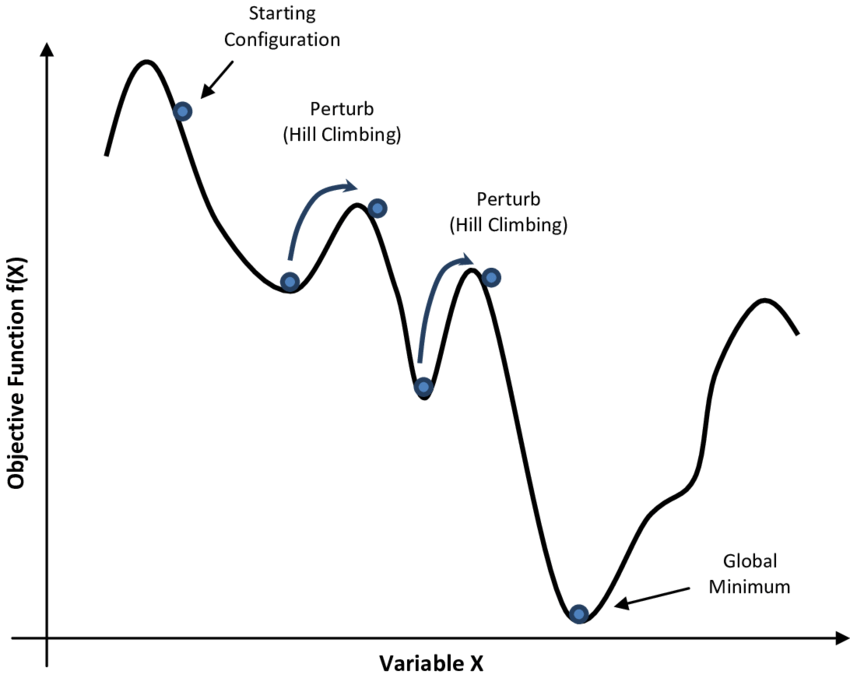
<source= (https://images.app.goo.gl/gB4mSZYLenAeF7QK8)>

In [20]:
## setup Simulated-Annealing
solver_sa = neal.SimulatedAnnealingSampler()
optimisation_sa = solver_sa.sample(portfolio_bqm, num_sweeps= 16, num_sweeps_per_beta= 2, 
                             num_reads= 100 ,beta_schedule_type= 'linear',
                             seed= 512034) ## modify seed for different runs a new experiment


In [21]:
optimisation_sa.info

{'beta_range': [117.34924261725294, 71241.45702813113],
 'beta_schedule_type': 'linear',
 'timing': {'preprocessing_ns': 1632859,
  'sampling_ns': 369015,
  'postprocessing_ns': 816988}}

In [22]:
optimisation_sa.aggregate().to_pandas_dataframe()

,AAPL,AMZN,GOOGL,IBM,META,MSFT,NFLX,energy,num_occurrences
0,1,0,0,0,0,0,0,-0.000726,77
1,0,0,0,0,0,1,0,-0.000531,23


In [23]:
optimisation_sa.first

Sample(sample={'AAPL': 1, 'AMZN': 0, 'GOOGL': 0, 'IBM': 0, 'META': 0, 'MSFT': 0, 'NFLX': 0}, energy=-0.000726280353677511, num_occurrences=1)

##### Exact-Sampling

To check if we are obtaining a legitaimate solution we can run *Exact-Sampling*, which simply brute forces over all possible binary vectors (i.e all possible portfolios) to find the one with minimum energy. 

In [24]:
## setup Exact-Sampling 
from dimod import ExactSolver
solver_es = ExactSolver()
optimisation_es = solver_es.sample(portfolio_bqm)


In [25]:
optimisation_es.first ## 'first' return the state with minimal energy

Sample(sample={'AAPL': 1, 'AMZN': 0, 'GOOGL': 0, 'IBM': 0, 'META': 0, 'MSFT': 0, 'NFLX': 0}, energy=-0.0007262803536775122, num_occurrences=1)

In [26]:
optimisation_es.to_pandas_dataframe()

,AAPL,AMZN,GOOGL,IBM,META,MSFT,NFLX,energy,num_occurrences
0,0,0,0,0,0,0,0,0.000000,1
1,0,0,0,0,0,1,0,-0.000531,1
2,1,0,0,0,0,1,0,-0.000427,1
3,1,0,0,0,0,0,0,-0.000726,1
4,1,0,0,1,0,0,0,-0.000420,1
...,...,...,...,...,...,...,...,...,...
123,1,0,0,1,1,0,0,0.001564,1
124,1,0,0,0,1,0,0,0.000915,1
125,1,0,0,0,1,1,0,0.002098,1
126,0,0,0,0,1,1,0,0.001089,1


Here we can verify that the solution from `optimsation_sa` is certainly the one with the lowest energy as it same even in `optimisation_es`

In [27]:
low_energy_filter = lambda x: np.abs(portfolio_bqm.energy(x) - portfolio_bqm.energy(optimisation_es.first.sample)) < 0.001 

### Quantum Optimisation 

Now we will move to quantum algorithm that could help us with solving such problems. Broadly quantum computers can be classified into two types first one being Annealer based quantum computation and the other one being Circuit based quantum computation, and both of them work on distinct fundamental principles and require different type of hardware to be implemented. From a practical point of view annealer based quantum devices are more suited for solving optimisation problems beacuse the resource reqruiements do not scale up significantly with the problem size, however circuit based quantum devices are more accurate and are also also more versatile for different computational tasks but they require more sophisticated hardware than the former. 

#### Quantum Annealer based implementation

Quantum-Annealeing is similar to the Simulated-Annealing, which is the classcal algorithm we used for solving your problem. The difference here is that the transitions are not caused by a temperature paramter as in the previous case but occurs due to a quantum phenomena calles *Quantum Tunneling*.

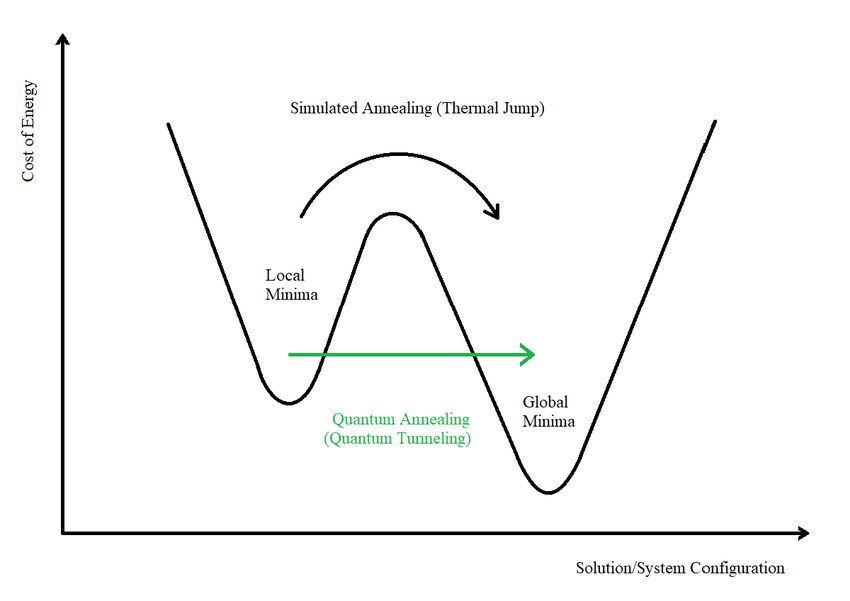

<figure taken from (https://images.app.goo.gl/BwCtQPQAM1BfEJiJA)>

We will use DWAVE's quantum services to run annealing based jobs, it provides sopisticated tools for handling tasks of different sizes. 

For our purpose we can either use a *Hybrid-Solver* which uses intensive classical preprocessing to reduce the amount of computation needed to be done on a quantum device and thus saving us some resources (running jobs on quantum devices are rather costly, so we want to spend least amount of time there;). Else we can use a full quantum olver called *Quantum Processing Unit (QPU)* which runs the full problem on quantum hardware.

Here we can use a QPU because the problems size is small (just a few variables), but for large problems using a hybrid solver is recommended. 

In [46]:
import dwave
from dwave.cloud import config, Client

In [29]:
## setup clinet to access dwave's cloud based service, you will need to setup your own configuration file 
client = Client.from_config(config.get_configfile_path())
dwave.cloud.config.load_config([config.get_configfile_path()]); 

In [49]:
from dwave.system import  LeapHybridSampler, DWaveSampler, EmbeddingComposite

In [33]:
## shows the type of solvers currently available underthe subscription 
Client.get_solvers(client)

[BQMSolver(id='hybrid_binary_quadratic_model_version2'),
 DQMSolver(id='hybrid_discrete_quadratic_model_version1'),
 CQMSolver(id='hybrid_constrained_quadratic_model_version1'),
 StructuredSolver(id='Advantage2_prototype1.1'),
 StructuredSolver(id='Advantage_system4.1'),
 StructuredSolver(id='Advantage_system6.3')]

In [48]:
## QPU based solver
solver_qpu = DWaveSampler()
solver_qpu.parameters,

({'anneal_offsets': ['parameters'],
  'anneal_schedule': ['parameters'],
  'annealing_time': ['parameters'],
  'answer_mode': ['parameters'],
  'auto_scale': ['parameters'],
  'flux_biases': ['parameters'],
  'flux_drift_compensation': ['parameters'],
  'h_gain_schedule': ['parameters'],
  'initial_state': ['parameters'],
  'max_answers': ['parameters'],
  'num_reads': ['parameters'],
  'programming_thermalization': ['parameters'],
  'readout_thermalization': ['parameters'],
  'reduce_intersample_correlation': ['parameters'],
  'reinitialize_state': ['parameters'],
  'warnings': [],
  'label': []},)

In [37]:
## Hybrid Solver
solver_lhs = LeapHybridSampler()
solver_lhs.default_solver, solver_lhs.properties

({'supported_problem_types__contains': 'bqm',
  'order_by': '-properties.version'},
 {'minimum_time_limit': [[1, 3.0],
   [1024, 3.0],
   [4096, 10.0],
   [10000, 40.0],
   [30000, 200.0],
   [100000, 600.0],
   [1000000, 600.0]],
  'maximum_time_limit_hrs': 24.0,
  'maximum_number_of_variables': 1000000,
  'maximum_number_of_biases': 200000000,
  'parameters': {'time_limit': 'Maximum requested runtime in seconds.'},
  'supported_problem_types': ['bqm'],
  'category': 'hybrid',
  'version': '2.2',
  'quota_conversion_rate': 20})

In [51]:
## send the job to the slected remote solver 
solver_qpu = EmbeddingComposite(solver_qpu) ## we add this line to help the quantum hardware 
optimisation_qpu = solver_qpu.sample(portfolio_bqm, num_reads= 100  )

In [55]:
## send the job to the slected remote solver 
optimisation_lhs = solver_lhs.sample(portfolio_bqm )

Once the job is submitted we can monitor its status in the DWAVE's Leap[dashboard](https://cloud.dwavesys.com/leap/)

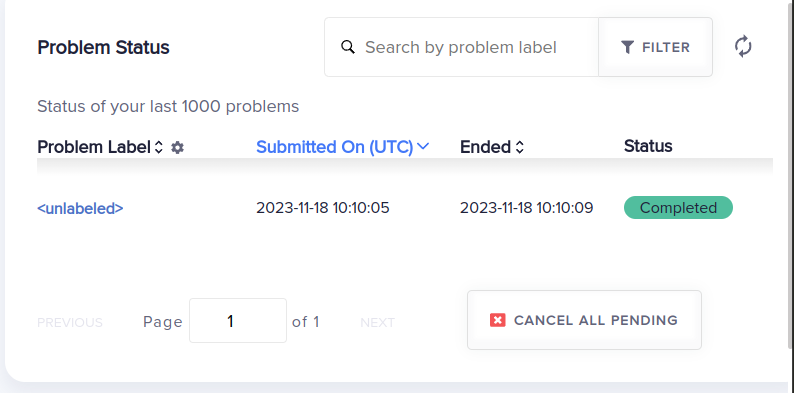

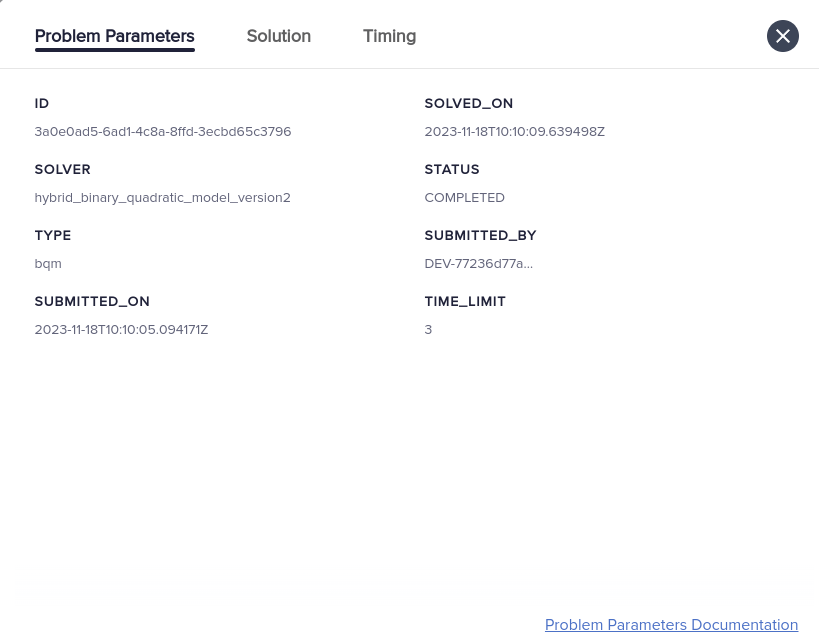

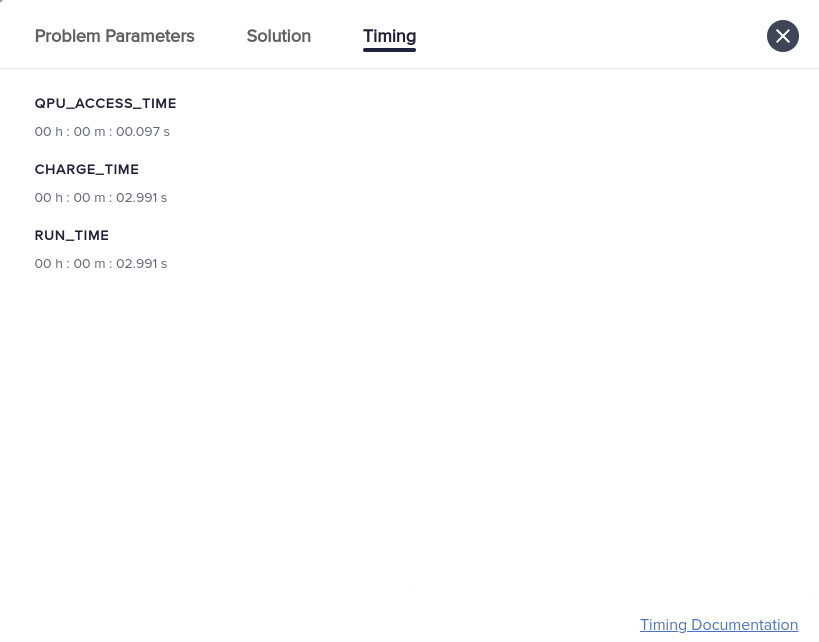

In [60]:
## solution from Hybrid Solver
optimisation_lhs.first, optimisation_lhs.to_pandas_dataframe()

(Sample(sample={'AAPL': 1, 'AMZN': 0, 'GOOGL': 0, 'IBM': 0, 'META': 0, 'MSFT': 0, 'NFLX': 0}, energy=-0.0007262803536775122, num_occurrences=1),
    AAPL  AMZN  GOOGL  IBM  META  MSFT  NFLX    energy  num_occurrences
 0     1     0      0    0     0     0     0 -0.000726                1)

In [61]:
## solution from QPU
optimisation_qpu.first, optimisation_qpu.to_pandas_dataframe()

(Sample(sample={'AAPL': 1, 'AMZN': 0, 'GOOGL': 0, 'IBM': 0, 'META': 0, 'MSFT': 0, 'NFLX': 0}, energy=-0.0007262803536775122, num_occurrences=77, chain_break_fraction=0.0),
    AAPL  AMZN  GOOGL  IBM  META  MSFT  NFLX  chain_break_fraction    energy  \
 0     1     0      0    0     0     0     0                   0.0 -0.000726   
 1     0     0      0    0     0     1     0                   0.0 -0.000531   
 2     1     0      0    1     0     0     0                   0.0 -0.000420   
 3     0     0      1    0     0     0     0                   0.0 -0.000337   
 4     1     0      1    0     0     0     0                   0.0 -0.000319   
 5     0     0      1    0     0     1     0                   0.0 -0.000073   
 
    num_occurrences  
 0               77  
 1               11  
 2                5  
 3                3  
 4                3  
 5                1  )

We can see both of the returned the same solution with high probability, note that this was also a solution with highst probability using classical methods.

#### Quantum Circuit Based Implementation

The previous algorithm was implemented on a Quantum Annealer, but now we will turn to solve it using a Quantum Circuit. There are certain differences between their working. Here the computation proceeds by direct application of quantum-gates on the wires of the quantum-circuit which is similar to classical circuits where computation is done by applying classical gates to the wires. 

For our implementation we will use IBM's qiskit which allows designing quantum circuits and provides interface to directly run them on IBMQ's quantum devices.

In [23]:
## We will need to convert the problem into a form suitable for qiskit 
## and for this we will use qiskit's QuadraticProgram class which allows creating quadratic problems.
from qiskit_optimization import QuadraticProgram

In [98]:
## define the QuadraticProgram and add variables 
portfolio_bqm_qiskit = QuadraticProgram('portfolio_bqm')
for varaibles in portfolio_bqm.data.variables :
    portfolio_bqm_qiskit.binary_var(name= varaibles)

In [104]:
## we extract the coefficients from the previous BQM model

quadratic = {}
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: quadratic[(stock_i, stock_j)] =  portfolio_bqm.get_quadratic(stock_i, stock_j)

linear = {}
for stock_i in stocks : linear[stock_i] = portfolio_bqm.get_linear(stock_i)

## we pass the extracted coeficients to the QuadraticProgram
portfolio_bqm_qiskit.minimize(linear= linear, quadratic= quadratic)

In [105]:
## see the optimisation problem
print(portfolio_bqm_qiskit.prettyprint())

Problem name: portfolio_bqm

Minimize
  0.009910695078030395*AAPL*AMZN + 0.009665379345921377*AAPL*GOOGL
  + 0.00544176801679447*AAPL*IBM + 0.011771399374041286*AAPL*META
  + 0.009713294043525873*AAPL*NFLX + 0.012404604629552524*AMZN*META
  + 0.012563980856093025*AMZN*NFLX + 0.009510595839659977*GOOGL*AMZN
  + 0.012297063336797769*GOOGL*META + 0.009321290155896502*GOOGL*NFLX
  + 0.003632459279828505*IBM*AMZN + 0.004995389969494512*IBM*GOOGL
  + 0.004443719222090434*IBM*META + 0.001933652921722994*IBM*NFLX
  + 0.010793913476218248*MSFT*AAPL + 0.009875648051831257*MSFT*AMZN
  + 0.010334289702089194*MSFT*GOOGL + 0.0053156308506883045*MSFT*IBM
  + 0.011484133223248864*MSFT*META + 0.009519613063021235*MSFT*NFLX
  + 0.01481722140494072*NFLX*META - 0.005083962475742585*AAPL
  + 0.001131238462453383*AMZN - 0.0023556838522593316*GOOGL
  - 0.0007841086838736856*IBM + 0.005152540690696025*META
  - 0.0037164657389650545*MSFT + 0.0010379304534182247*NFLX

Subject to
  No constraints

  Binary varia

As stated already there are multiple algorithms to solve quadratic optimisation of circuit-based quantum computer. Here we will focus on one such algorithm called the Quantum Approximate Optimisation Algorithms (QAOA). Intuitively this algorithm can be understood as the circuit-based analouge of Quantum Annealing discusses in the previous subsection. 

We will use qiskit's functionalities that allows seamless conversion of quadratic programs into QAOA circuits, and solve them 

In [27]:
from qiskit_optimization.converters import QuadraticProgramToQubo

In [129]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils.algorithm_globals import algorithm_globals

##### Simulation of QUantum Algorithm

In [139]:
algorithm_globals.random_seed = 13413 ## set a random seed
portfolio_qaoa = QAOA(sampler= Sampler(), reps= 5, optimizer= COBYLA())
portfolio_qaoa_solver = MinimumEigenOptimizer(portfolio_qaoa)


In [151]:
portfolio_bqm_hamiltonian = portfolio_bqm_qiskit.to_ising()[0]

In [157]:
from qiskit.circuit.library import QAOAAnsatz, TwoLocal

In [160]:
portfolio_qaoa_ansatz = QAOAAnsatz(portfolio_bqm_hamiltonian, reps =1, name= 'Portfolio Optimisation')

In [ ]:
portfolio_qaoa_ansatz.decompose(reps=3).draw()

In [131]:
# from qiskit.visualization import 
qaoa_result = portfolio_qaoa_solver.solve(portfolio_bqm_qiskit)

In [136]:
print(qaoa_result.prettyprint())

objective function value: -0.005083962475742585
variable values: MSFT=0.0, AAPL=1.0, IBM=0.0, GOOGL=0.0, AMZN=0.0, NFLX=0.0, META=0.0
status: SUCCESS


In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService